In [243]:
from datetime import datetime
from flask import Flask, jsonify, request
from flask_cors import CORS
import numpy as np
import matplotlib.pyplot as plt

from ifem_award_api.app import generate_mock_patients

import copy
import itertools
from deap import base, creator, tools, algorithms
import random

In [177]:
estimated_operation_time = {
    1: 20,
    2: 30,
    3: 15,
    4: 10,
    5: 10,
}



doctors_list = [{
    'id':61269123,
    'status':'available'
},{
    'id':61269124,
    'status':'available'}
]


patients = generate_mock_patients()

def get_stats():
    mock_patients = patients
    category_breakdown = {i: 0 for i in range(1, 6)}
    wait_times = {i: [] for i in range(1, 6)}
    
    for patient in mock_patients:
        category = patient.triage_category.value
        category_breakdown[category] += 1
        wait_times[category].append(patient.time_elapsed)
    
    average_wait_times = {
        category: round(sum(times) / len(times)) if times else 0
        for category, times in wait_times.items()
    }
    
    return {
        'categoryBreakdown': category_breakdown,
        'averageWaitTimes': average_wait_times
    }

for element in patients:
    element.estimated_operation_time = estimated_operation_time[element.triage_category.value]

get_stats()


{'categoryBreakdown': {1: 0, 2: 4, 3: 9, 4: 10, 5: 2},
 'averageWaitTimes': {1: 0, 2: 22, 3: 86, 4: 151, 5: 276}}

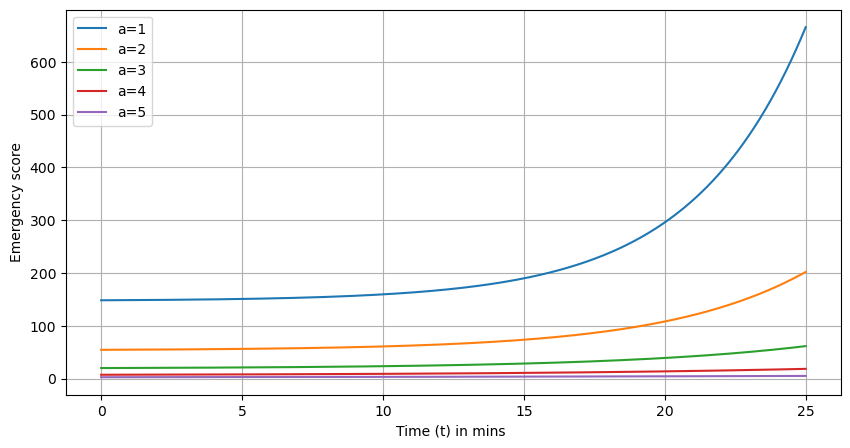

In [169]:

def damage(a, t):
    return np.exp(0.05 * np.abs(6 - a)*t) - 1 + np.exp(np.abs(6 - a)) 

a_values = np.arange(1, 6)
t_values = np.linspace(0, 25, 400)  

plt.figure(figsize=(10, 5))
for a in a_values:
    f_values = damage(a, t_values)
    plt.plot(t_values, f_values, label=f'a={a}')

plt.xlabel('Time (t) in mins ')
plt.ylabel('Emergency score')
plt.legend()
plt.grid(True)
plt.show()

In [189]:
def calculate_emergency_score(ordera, doctors_og):
    doctors = copy.deepcopy(doctors_og)
    order = copy.deepcopy(ordera)
    emergency_score = 0
    max_time = 0
    docs_available = len([element for element in doctors if element['status'] == 'available'])
    for (keys,vals) in get_stats()['categoryBreakdown'].items():
        max_time += vals * estimated_operation_time[keys]
    batch = [element for element in patients if element.status == 'in_progress']
    docs_available = len([element for element in doctors if element['status'] == 'available'])
    for t in range (0, max_time):
        for patient in batch:
            patient.estimated_operation_time -= 1
            if patient.estimated_operation_time == 0:
                docs_available += 1
                patient.status = 'completed'
                for element in doctors:
                    if element['status'] == 'busy':
                        element['status'] = 'available'
                        break
                batch.remove(patient)
        if order == []:
            break
        while docs_available != 0:
            next = 0
            #for i in range(len(order)):
                #if order[i].status['investigations']['labs'].value != 'ordered' and order[i].status['investigations']['imaging'].value != 'ordered':
                    #next = i
                    #break
            next_patient = order.pop(next)
            emergency_score += damage(next_patient.triage_category.value, t+next_patient.time_elapsed)
            batch.append(next_patient)
            next_patient.status = 'in_progress'
            for element in doctors:
                if element['status'] == 'available':
                    element['status'] = 'busy'
                    break
            docs_available -= 1
        
    return emergency_score
calculate_emergency_score(patients, doctors_list)


3.4471963267309404e+18

In [218]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(patients)), len(patients))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

def evaluate(individual):
    order = [patients[i] for i in individual]
    in_progress = [element for element in order if element.status == 'in_progress']
    class1_patients = [element for element in order if (element.triage_category.value == 1 and element.status != 'in_progress')]
    remaining_patients = [element for element in order if (element not in in_progress and element not in class1_patients)]
    order = in_progress + class1_patients + remaining_patients
    return calculate_emergency_score(order, doctors_list),

toolbox.register("evaluate", evaluate)

def find_optimal_order(patients):
    for element in patients:
        element.estimated_operation_time = estimated_operation_time[element.triage_category.value]

    population = toolbox.population(n=100)
    ngen = 50
    cxpb = 0.7
    mutpb = 0.2

    

    result, log = algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, verbose=False)

    best_individual = tools.selBest(result, 1)[0]
    #best_individual = hall_of_fame[0]
    best_order = [patients[i] for i in best_individual]
    lowest_score = evaluate(best_individual)[0]

    return best_order, lowest_score

def get_optimal_order(n_iter):
    best = []
    lowest = float('inf')
    for i in range(n_iter):
        best_order, lowest_score = find_optimal_order(patients)
        if lowest_score < lowest:
            best = best_order
            lowest = lowest_score
    
    return best_order, lowest_score

/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [214]:


#optimal_order, min_score = find_optimal_order(patients)
optimal_order, min_score = get_optimal_order(5)

print("Optimal order of patients:")
for patient in optimal_order:
    print(f"Patient ID: {patient.id}, Triage Category: {patient.triage_category.value}, time elapsed : {patient.time_elapsed}")

print("Minimum emergency score:", min_score)

Optimal order of patients:
Patient ID: anon_4233, Triage Category: 3, time elapsed : 43
Patient ID: anon_4233, Triage Category: 3, time elapsed : 43
Patient ID: anon_4233, Triage Category: 3, time elapsed : 43
Patient ID: anon_2792, Triage Category: 2, time elapsed : 26
Patient ID: anon_2792, Triage Category: 2, time elapsed : 26
Patient ID: anon_5730, Triage Category: 4, time elapsed : 125
Patient ID: anon_4214, Triage Category: 3, time elapsed : 106
Patient ID: anon_6880, Triage Category: 3, time elapsed : 63
Patient ID: anon_9529, Triage Category: 4, time elapsed : 225
Patient ID: anon_4214, Triage Category: 3, time elapsed : 106
Patient ID: anon_5822, Triage Category: 4, time elapsed : 71
Patient ID: anon_1758, Triage Category: 3, time elapsed : 114
Patient ID: anon_8735, Triage Category: 3, time elapsed : 105
Patient ID: anon_2792, Triage Category: 2, time elapsed : 26
Patient ID: anon_4214, Triage Category: 3, time elapsed : 106
Patient ID: anon_9024, Triage Category: 4, time ela

(array([45.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([1.14804411e+03, 4.28900355e+05, 8.56652667e+05, 1.28440498e+06,
        1.71215729e+06, 2.13990960e+06, 2.56766191e+06, 2.99541422e+06,
        3.42316653e+06, 3.85091885e+06, 4.27867116e+06, 4.70642347e+06,
        5.13417578e+06, 5.56192809e+06, 5.98968040e+06, 6.41743271e+06,
        6.84518502e+06, 7.27293733e+06, 7.70068965e+06, 8.12844196e+06,
        8.55619427e+06, 8.98394658e+06, 9.41169889e+06, 9.83945120e+06,
  

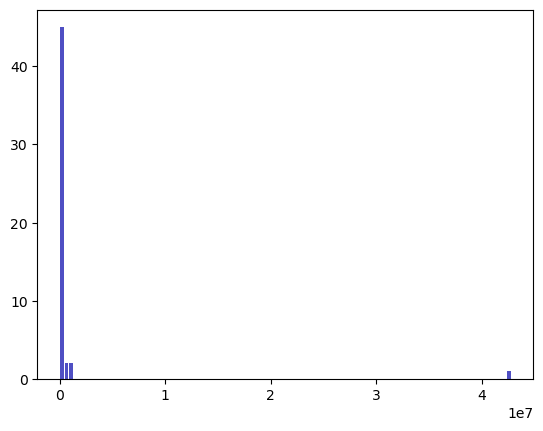

In [220]:
min_scores = []
for i in range(50):
    min_scores.append(get_optimal_order(5)[1])
plt.hist(min_scores, bins=100, color='#0504aa', alpha=0.7, rwidth=0.85)


(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0., 16.,
         0.,  0.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([3.05995858, 3.10567103, 3.15138348, 3.19709594, 3.24280839,
        3.28852085, 3.3342333 , 3.37994576, 3.42565821, 3.47137067,
        3.51708312, 3.56279557, 3.60850803, 3.65422048, 3.69993294,
        3.74564539, 3.79135785, 3.8370703 , 3.88278276, 3.92849521,
        3.97420766, 4.01992012, 4.06563257, 4.11134503, 4.15705748,
        4.20276994, 4.24848239, 4.29419485, 4.3399073 , 4.38561975,
        4.43133221, 4.4770

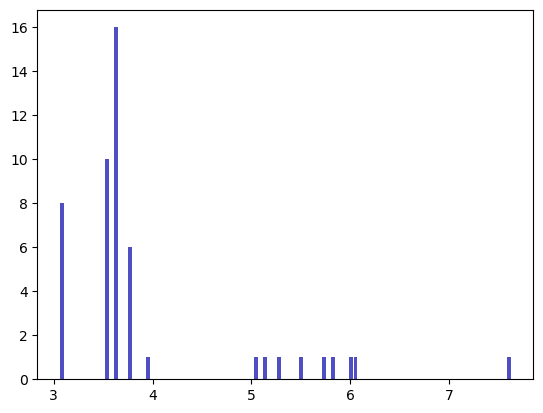

In [226]:
plt.hist(np.log10(min_scores), bins=100, color='#0504aa', alpha=0.7, rwidth=0.85)

In [242]:
import numpy as np
import tensorflow as tf
from keras import layers, models

# Generate some example data
minimum = min(min_scores)
np.random.seed(42)
data = [element for element in min_scores if element <= 1.1*minimum] 
outliers = [element for element in min_scores if element not in data]  # Outlier data
for i in range (100) :
    data.append(random.uniform(1*minimum, 1.1*minimum))
data = np.concatenate([data, np.array(outliers)])
np.random.shuffle(data)
# Normalize the data
data_mean = np.mean(data)
data_std = np.std(data)
data_normalized = (data - data_mean) / data_std

# Split the data into training and test sets
train_data = data_normalized[:len(data_normalized) - 10]
test_data = data_normalized[len(data_normalized)-10:]
test_data = np.append(test_data, outliers[0])

# Define the autoencoder model
input_dim = 1
encoding_dim = 2

input_layer = layers.Input(shape=(input_dim,))
encoder = layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = layers.Dense(input_dim, activation="linear")(encoder)

autoencoder = models.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Train the autoencoder
autoencoder.fit(train_data, train_data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# Use the autoencoder to reconstruct the test data
reconstructed_data = autoencoder.predict(test_data)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.square(test_data - reconstructed_data), axis=1)

# Set a threshold for outlier detection
threshold = np.percentile(reconstruction_error, 95)

# Detect outliers
outliers = reconstruction_error > threshold

print("Detected outliers:", np.where(outliers)[0], test_data[np.where(outliers)[0]])

def is_outlier(value):
    normalized_value = (value - data_mean) / data_std
    reconstructed_value = autoencoder.predict(np.array([[normalized_value]]))
    error = np.mean(np.square(normalized_value - reconstructed_value))
    return error > threshold

# Example usage
value_to_check = outliers[0]
value_to_check

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8467 - val_loss: 0.0072
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2409 - val_loss: 0.0068
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8454 - val_loss: 0.0065
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8450 - val_loss: 0.0061
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8445 - val_loss: 0.0058
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2384 - val_loss: 0.0055
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3083 - val_loss: 0.0052
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8433 - val_loss: 0.0050
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5332 - val_loss: 0.0047
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8425 - val_loss: 0.0046
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2352 - val_loss: 0.0044
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8418 - val_loss: 0.0042
Epoch 13/50

True